In [5]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [6]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [7]:
len(words)

32033

In [8]:
# building the vocabulary of charcters and mappings to integers and integer to characters
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [9]:
block_size = 3 # context length from how man y words we predict the next one

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

xtr,  ytr  = build_dataset(words[:n1])     # 80%
xdev, ydev = build_dataset(words[n1:n2])   # 10%
xte,  yte  = build_dataset(words[n2:])     #10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [11]:

n_embd = 10 # the dimensionality of the character look up we can multiply it with block size
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)*(5/3)/((n_embd * block_size)**0.5) #scaling factor for tanh is 5/3 and here divide with sqrt of fanin
#b1 = torch.randn(n_hidden,                        generator=g)*0.01 no need because it has own bias
W2 = torch.randn((n_hidden, vocab_size),          generator=g)*0.01 
# b2 = torch.randn(vocab_size,                      generator=g)*0  # multiply with 0 to reduce the logits value closer to 0
#batchnorm parameters
bngain=torch.ones(1,n_hidden) 
bnbias=torch.zeros(1,n_hidden) # has its own bias
bnmean_running=torch.zeros(1,n_hidden)
bnstd_running=torch.ones(1,n_hidden)
parameters = [C, W1, W2,bngain,bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True #it keep tracks the gradient

12070


In [ ]:
# using xtr and ytr
max_steps=200000
batch_size=32 #using  minibatch
lossi=[]
for i in range(max_steps):
    ix=torch.randint(0,xtr.shape[0],(batch_size,),generator = g) #mini batch constructed
    xb,yb=xtr[ix],ytr[ix]
    emb=C[xb] #32,3,10
    embcat=emb.view(emb.shape[0],-1) #in -1 pytorch automatically assigns the value
    hpreact=embcat @ W1 #+b1  #hidden layer pre activation
    bnmeani=hpreact.mean(0,keepdim=True)
    bnstdi=hpreact.std(0,keepdim=True)
    hpreact=bngain*(hpreact-bnmeani)/bnstdi+bnbias #batch normalization layer has bnbias in own so no need to add ext bias

    with torch.no_grad():
         bnmean_running=0.999*bnmean_running+0.001*bnmeani #these are inferences used for the testing and validatiio after the completion of training
         bnstd_running=0.999*bnstd_running+0.001*bnstdi
    h=torch.tanh( hpreact)
    logits=h @ W2 #+b2
    loss=F.cross_entropy(logits,yb)# loss function

    #backward pass 
    for p in parameters:
         p.grad=None
    loss.backward()
    #update
    lr=0.1 if i<10000 else 0.01
    for p in parameters:
         p.data+=-lr*p.grad
    if i%10000==0:
         print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}')
    lossi.append(loss.log10().item())
    break

      0/ 200000:3.2993


In [21]:
hpreact.mean(1,keepdim=True).shape

torch.Size([32, 1])

In [ ]:
torch.randint(0,xtr.shape[0],(batch_size,),generator = g)

tensor([109738,  58041, 156846,  75401,  78923, 144862, 120627,  31966, 182215,
         82553, 122874,   5197,  99677, 101728,  53213, 114200, 168023,  97806,
         20987,  61970,  94015, 126530, 113257,  77965, 113535,  70576,  80528,
        137928, 151628,  78797, 102637, 174851])

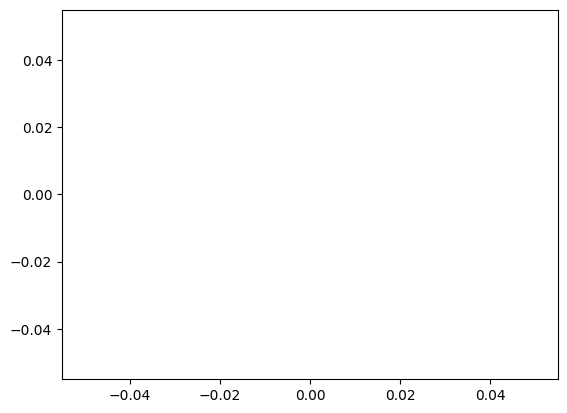

In [ ]:
plt.plot(lossi)

In [ ]:
logits[0]

tensor([ 0.3235,  1.6155, -0.3374, -0.1513,  0.1588,  1.2646, -1.1294, -0.8049,
         0.0685,  1.2868, -0.7514, -0.1412,  0.9358,  0.0152,  0.7865,  0.3808,
        -0.9828, -1.5189,  0.7542,  0.7803,  0.1812, -0.1881, -0.5730, -1.0899,
        -1.1459,  0.7107, -0.5058], grad_fn=<SelectBackward0>)

In [ ]:
#Saturated-when the act func produces output very close to the input values
#non linearity is function where output change does not directly propotional to input
#when we use relu it destroys half in the negative site , to compensate this with a gain we use sd=sqrt(2/N_in)(using kaiming init techniq for weight adjustment)
#formula for weigt adjusment in tanh ==gain/sqrt(fanin)
#A Gaussian distribution with zero mean and controlled variance ensures weights stay in a balanced range.(for relu and tanh)
#in batch normalization reduce the loss by adjusting the mean and variance across a mini batch
#have a screenshot for formulas normalize the hidden hpreact layer using gaussian distribution

In [ ]:
torch.no_grad() #this disables gradient tracking
emb=C[xtr] #(N,blocksize,n_embd)
embcat=emb.view(emb.shape[0],-1) #concat with (N,blocksize* n_embd)
hpreact=embcat @ W1 #b1 #N,n_hidden 
bnmean=hpreact.mean(0,keepdim=True)
bnstd=hpreact.std(0,keepdim=True)
# hpreact=bngain*(hpreact-(hpreact.mean(0,keepdim=True)))/hpreact.std(0,keepdim=True)+bnbias

In [ ]:
@torch.no_grad() #this disables gradient tracking
def split_loss(split):
    x,y={ 
    'train' : (xtr,ytr),
    'val' : (xdev,ydev),
    'test': (xte,yte),
    }[split] # it takes the train and val string in the list
    emb=C[x] #(N,blocksize,n_embd)
    embcat=emb.view(emb.shape[0],-1) #concat with (N,blocksize* n_embd)
    hpreact=embcat @ W1  #b1 #N,n_hidden 
    hpreact=bngain*(hpreact-bnmeani)/bnstdi+bnbias
    h=torch.tanh( hpreact)
    logits=h @ W2 b2
    loss=F.cross_entropy(logits,y)# loss function
    print(split,loss.item())
split_loss('train')
split_loss('val')

SyntaxError: invalid syntax (338868846.py, line 13)

In [ ]:
# loss 
#  fix softmax confidently wrong---->
# train 2.1446988582611084
# val 2.1785755157470703
#fix tanh layer saturated at init------>
# train 2.100076198577881
# val 2.1391818523406982
#use semi principled kaiming init instead of hacky init(ie multiply the weight by gain divided by sqrt(fanin))
# train 2.0994210243225098
# val 2.1359660625457764
#Add a batch norm layer


In [ ]:
# plt.hist(h.view(-1).tolist(),50); #tanh doesn't affect the loss because it is a flat surface(refer tanh backward in micrograd)

In [ ]:
# plt.figure(figsize=(20,10))
# plt.imshow(h.abs() > 0.99,cmap='grey',interpolation='nearest')
#in 200 colums if one row is fully white (i.e) true is dead neuron and does not learn anything

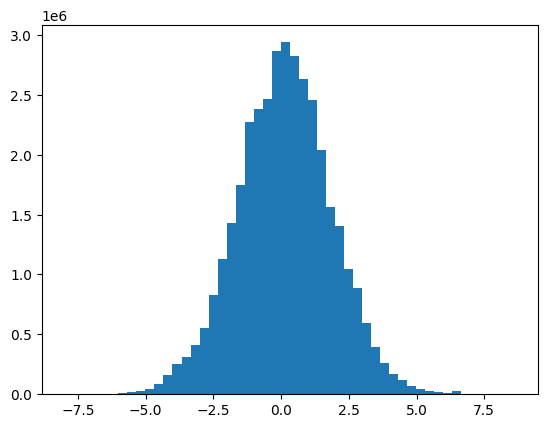

In [ ]:
plt.hist(hpreact.view(-1).tolist(),50);

In [ ]:
(torch.rand(1000)*0.2).std()

tensor(0.0575)

tensor(-0.0195) tensor(1.0071)
tensor(0.0063) tensor(1.0165)


(array([2.15994835e-05, 0.00000000e+00, 2.15994835e-05, 8.63979340e-05,
        1.29596901e-04, 1.72795868e-04, 3.88790703e-04, 7.99180890e-04,
        9.71976758e-04, 2.03035145e-03, 2.57033854e-03, 5.16227656e-03,
        7.81901303e-03, 1.22037082e-02, 1.82515636e-02, 3.00016826e-02,
        4.50565226e-02, 6.66992051e-02, 9.83424484e-02, 1.39856656e-01,
        1.91587419e-01, 2.48221265e-01, 3.16562030e-01, 3.68724783e-01,
        4.14558887e-01, 4.28879345e-01, 4.07517455e-01, 3.60257785e-01,
        3.07209454e-01, 2.45067740e-01, 1.83574010e-01, 1.35795953e-01,
        9.62904975e-02, 6.55112335e-02, 4.26589799e-02, 2.84681193e-02,
        1.78843723e-02, 1.17285195e-02, 7.27902594e-03, 4.64388896e-03,
        2.89433079e-03, 1.44716540e-03, 9.28777791e-04, 6.91183472e-04,
        4.31989670e-04, 3.23992253e-04, 6.47984505e-05, 4.31989670e-05,
        2.15994835e-05, 4.31989670e-05]),
 array([-5.88490343, -5.65341641, -5.4219294 , -5.19044238, -4.95895536,
        -4.72746835, 

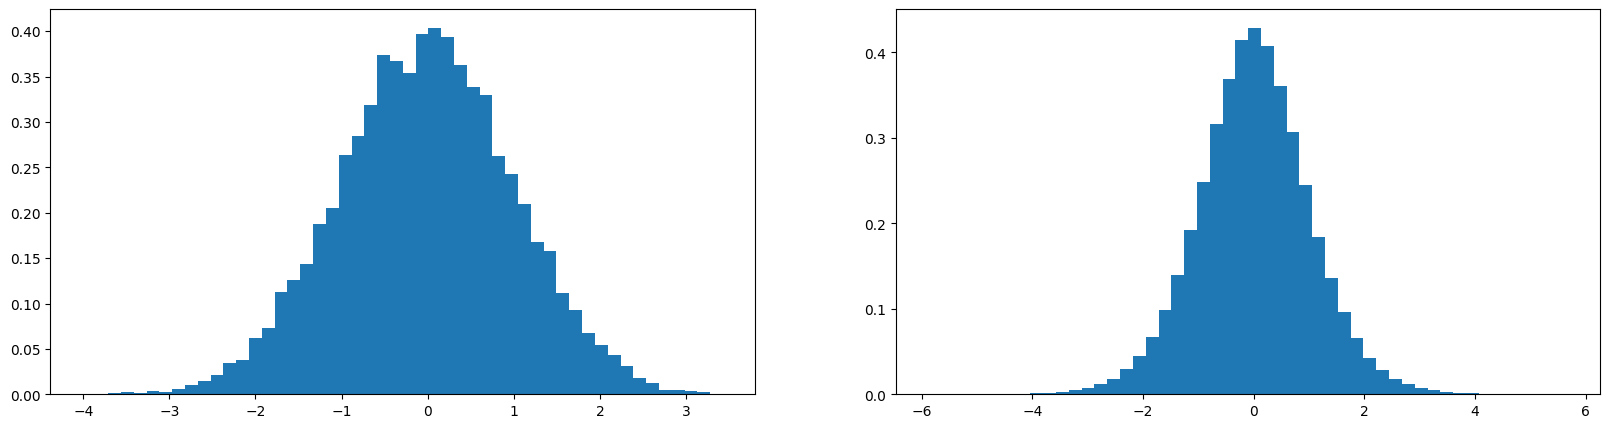

In [ ]:
x=torch.randn(1000,10)
w=torch.randn(10,200) /10**0.5
y=x@w
print(x.mean(),x.std())
print(y.mean(),y.std())
plt.figure(figsize=[20,5])
plt.subplot(121)
plt.hist(x.view(-1).tolist(),50,density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(),50,density=True)
